In [1]:
from model.tensorflow.yolo.yolo import YOLO, decode, compute_loss, decode_train
from model.tensorflow.yolo.dataset import Dataset
import tensorflow as tf

import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2

plt.rcParams["figure.figsize"] = (20,10)

2022-08-16 15:30:53.579734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [275]:
def createLabel(filename, time1, time2):
    # image = cv2.imread(filename)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # plt.rcParams["figure.figsize"] = (30,15)

    label = []

    h1_1 = int(time1[0])
    h1_2 = int(time1[1])

    m1_1 = int(time1[2])
    m1_2 = int(time1[3])
    # 시 십단위
    if (h1_1 == 1):
        label.append([374, 607, 382, 632, h1_1])
    elif (h1_1 > 0) : 
        label.append([368, 607, 382, 632, h1_1]) 

    # 시 일단위
    if (h1_2 == 1):
        label.append([386, 607, 396, 632, h1_2]) 
    else: 
        label.append([382, 607, 394, 632, h1_2])

    label.append([392, 611, 400, 627, ':']) # :

    # 분 십단위
    if (m1_1 == 1):
        label.append([402, 607, 410, 632, m1_1]) # 분 십단위 1
    else: 
        label.append([397, 607, 410, 632, m1_1]) # 분 십단위

    # 분 일단위
    if (m1_2 == 1):
        label.append([418, 607, 426, 632, m1_2]) # 분 십단위 1
    else: 
        label.append([411, 607, 426, 632, m1_2]) # 분 십단위

    # 좌측 습도 
    label.append([440, 601, 453, 619, 2])
    label.append([452, 601, 463, 619, 0])

    #좌측 온도
    label.append([441, 618, 453, 637, 3])
    # label.append([453, 618, 464, 637, 1])  # <----------- 변동
    label.append([465, 618, 474, 631, 'c']) # c

    # 우측온도
    label.append([571, 558, 580, 576, 3]) # 고정
    # label.append([582, 554, 591, 576, 1]) # <----------- 변동
    # label.append([594, 554, 602, 576, 1]) # <----------- 변동

    if int(time2[0:2]) > 12:
        time2 = '{:02d}{}'.format(int(time2[0:2]) - 12, time2[2:4])

    # # 우측 시계
    h2_1 = int(time2[0])
    h2_2 = int(time2[1])

    m2_1 = int(time2[2])
    m2_2 = int(time2[3])

    # 시 십단위
    if (h2_1 == 1):
        label.append([573, 597, 576, 608, h2_1]) 
    elif (h2_1 > 0) : 
        label.append([569, 597, 576, 608, h2_1])

    # 시 일단위
    if (h2_2 == 1):
        label.append([580, 597, 584, 608, h2_2])
    else: 
        label.append([577, 597, 584, 608, h2_2])

    # 분 십단위
    if (m2_1 == 1):
        label.append([591, 597, 595, 608, m2_1]) # 1
    else: 
        label.append([588, 597, 595, 608, m2_1])

    # 분 일단위
    if (m2_2 == 1):
        label.append([598, 597, 601, 608, m2_2]) # 1
    else: 
        label.append([596, 597, 601, 608, m2_2])


    xml_str = '<folder>data</folder><path/><segmented>0</segmented><source><database>Unknown</database></source><filename>{}</filename><size><width>1920</width><height>1080</height><depth>3</depth></size>'.format(filename)
    for o in label:
        xml_str += "<object><pose>Unspecified</pose><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>{}</xmin><ymin>{}</ymin><xmax>{}</xmax><ymax>{}</ymax></bndbox><name>{}</name></object>".format(o[0], o[1], o[2], o[3], o[4])

    return '<?xml version="1.0"?><annotation>{}</annotation>'.format(xml_str)

In [276]:
import os
import glob
import datetime

In [278]:
files = glob.glob('auto/*.jpg')
files.sort()

hm1 = datetime.datetime(2019, 1, 7, 19, 27, 0)
hm2 = datetime.datetime(2019, 1, 7, 9, 16, 0)

for idx, f in enumerate(files):
    filename = os.path.basename(f)
    t1 = hm1.strftime('%H%M')
    t2 = hm2.strftime('%H%M')

    x = createLabel(filename, t1,t2)

    with open('./annotation/{}.xml'.format(filename).replace(".jpg",""), 'w') as xmlfile:
        xmlfile.write(x)

    hm1 += datetime.timedelta(minutes=1)
    hm2 += datetime.timedelta(minutes=1)


# files = glob.glob('auto/*.jpg')
# files.sort()

# hm1 = datetime.datetime(2019, 1, 7, 6, 0, 0)
# hm2 = datetime.datetime(2019, 1, 7, 12, 27, 0)

# for idx, f in enumerate(files):
#     filename = os.path.basename(f)
#     t1 = hm1.strftime('%H%M')
#     t2 = hm2.strftime('%H%M')

#     x = createLabel(filename, t1,t2)

#     with open('./annotation/{}.xml'.format(filename).replace(".jpg",""), 'w') as xmlfile:
#         xmlfile.write(x)

#     hm1 += datetime.timedelta(minutes=1)
#     hm2 += datetime.timedelta(minutes=1)

# 데이터 Auggmentation

In [3]:
import cv2
import matplotlib.pyplot as plt
import os 
import random

* 스케일 조정
* 샘플링 위치 

In [11]:
start_x = 370
start_y = 550
start_w = 250
start_h = 100

xywh = (start_x,start_y, start_w, start_h)

max_w = 2*start_x + start_w
max_h = 2* start_y + start_h
max_w, max_h

(990, 1200)

In [22]:
y = 100, 120
x = 150, 250

In [26]:
min(120, 250) - max(100, 150)

-30

In [14]:
100-250

-150

In [28]:
box = 263,318,274,331

In [30]:
area = max(0, (min(box[2], 420) - max(box[0], 360))) * (min(box[3], 310) - max(box[1], 250))
area

688

In [31]:
(min(box[2], 420) - max(box[0], 360))

-86

In [32]:
(min(box[3], 310) - max(box[1], 250))

-8

In [33]:
with open('dataset/server_room_aug/train_digit_zoom_left_clock.txt', 'w') as new_f:

    for aug_idx in range(1):
        with open('dataset/server_room_aug/train_digit_zoom_daylight.txt') as f:
            preview = 0
            for row in f.readlines():
                if preview < 5:
                    preview += 1

                # x1 = random.randrange(left_margin[0], left_margin[1])
                # x2 = random.randrange(right_margin[0], right_margin[1])
                # y1 = random.randrange(top_margin[0], top_margin[1])
                # y2 = random.randrange(bottom_margin[0], bottom_margin[1])

                # x1 = 200
                # x2 = 800
                # y1 = 300
                # y2 = 900

                bbox = ""
                cols = row.split()
                for idx, value in enumerate(cols):
                    if idx == 0:
                        filepath = value
                        # new_line = filepath
                    else:
                        box = value.split(',')
                        box[0] = int(box[0]) # - x1
                        box[1] = int(box[1]) # - y1
                        box[2] = int(box[2]) # - x1
                        box[3] = int(box[3]) # - y1

                        area = max(0,(min(box[2], 420) - max(box[0], 360))) * max(0,(min(box[3], 310) - max(box[1], 250)))

                        if area > 0:
                            print(value, area)
                            continue

                        if box[4] == '10' or box[4] == '11':
                            continue
                        
                        bbox += (" {},{},{},{},{}".format(box[0],box[1],box[2],box[3],box[4]))

                filename = os.path.basename(filepath)
                filename, ext = os.path.splitext(filename)
                filename = '{}_{}{}'.format(filename, aug_idx, ext)
                # print(filename)
                new_path = os.path.join('./dataset/server_room_aug/train_zoom_left_clock', filename)
                new_line = new_path + bbox
                new_f.write(new_line+'\n')

                # img = cv2.imread(filepath)
                # cv2.rectangle(img, (360, 250), (420,310), (128,128,128), -1)
                # cv2.imwrite(new_path, img)

371,258,380,276,3 162
382,258,391,275,4 153
377,297,384,308,5 77
388,297,395,308,5 77
393,260,403,276,5 160
394,296,402,309,9 104
380,297,384,308,1 44
371,258,380,276,3 162
388,297,395,308,4 77
382,258,391,274,4 144
394,259,402,275,5 128
396,297,401,308,9 55
377,297,384,308,0 77
373,297,376,308,1 33
371,258,380,276,3 162
383,258,391,275,4 136
388,297,395,308,5 77
394,297,402,308,5 88
380,297,384,308,1 44
391,297,395,308,1 44
371,258,380,276,3 162
382,259,391,275,4 144
395,297,402,307,4 70
394,259,402,275,6 128
380,297,384,308,1 44
394,297,402,308,2 88
371,258,380,276,3 162
381,258,392,276,4 198
388,297,395,308,5 77
394,258,403,275,7 153
395,297,402,308,0 77
371,258,380,276,3 162
387,297,394,308,3 77
382,258,391,274,4 144
393,258,402,276,6 162
377,297,384,308,9 77
394,297,401,308,0 77
394,258,402,274,2 128
387,296,393,308,2 72
371,258,380,276,3 162
382,259,391,274,4 135
377,297,384,308,5 77
388,297,395,308,0 77
380,297,384,308,1 44
371,258,380,276,3 162
381,258,391,274,4 160
393,259,402

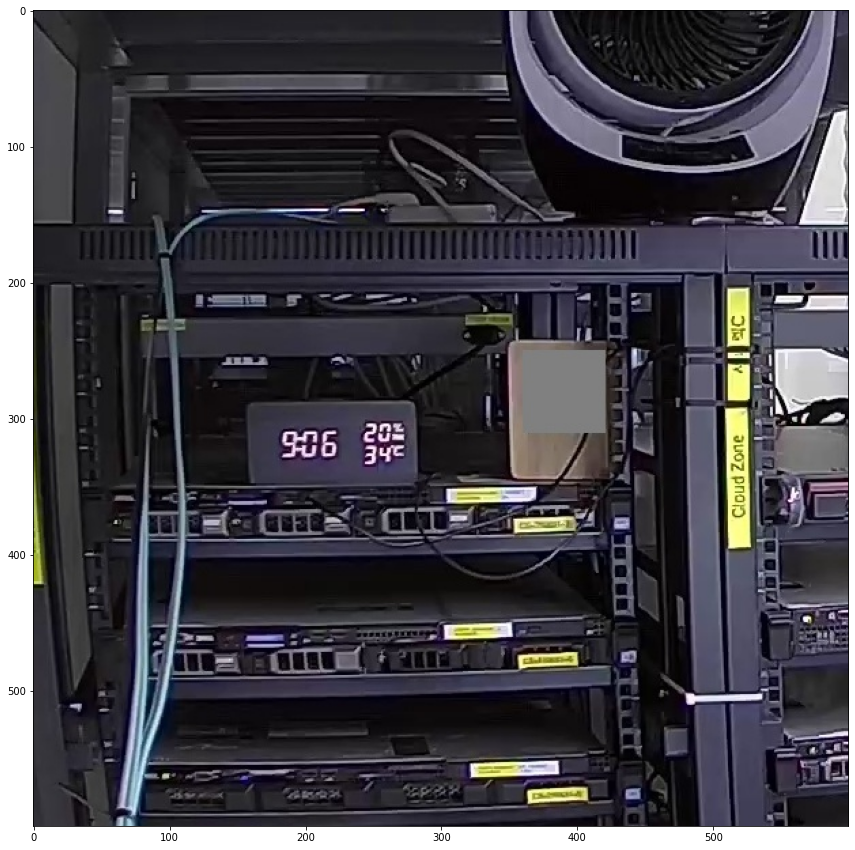

In [17]:
p  = './dataset/server_room_aug/train_zoom_left_clock/0907_image_4_0_0.jpg'
img = cv2.imread(p)
# img = img[start_y:start_y+start_h, start_x:start_x+start_w, :]
# img = cv2.resize(img, (419,419))


# cv2.rectangle(img, (360, 250), (420,310), (128,128,128), -1)

# x1 = 200
# x2 = 800
# y1 = 300
# y2 = 900

# img = img[y1:y2, x1:x2, :]

plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
left_margin = (0, start_x)
right_margin = (start_x + start_w, max_w)
top_margin = (0, start_y)
bottom_margin = (start_y + start_h, max_h)
left_margin, right_margin, top_margin, bottom_margin

((0, 370), (620, 990), (0, 550), (650, 1200))

In [13]:
x1 = random.randrange(left_margin[0], left_margin[1])
x2 = random.randrange(right_margin[0], right_margin[1])
y1 = random.randrange(top_margin[0], top_margin[1])
y2 = random.randrange(bottom_margin[0], bottom_margin[1])

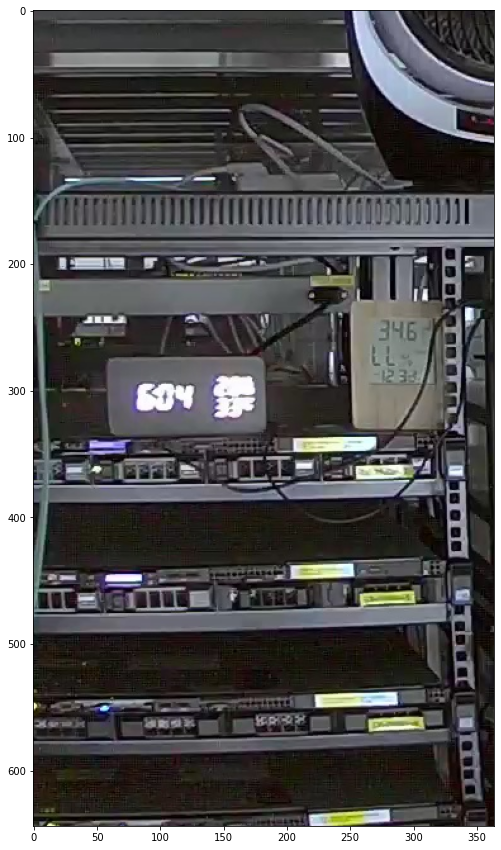

In [49]:
p  = '/Users/handh/dev/workspace/python/didimdol_ai_model/dataset/server_room/train/0605_image_4.jpg'
img = cv2.imread(p)
img = img[y1:y2,x1:x2 :]
# img = cv2.resize(img, (419,419))

plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
with open('dataset/server_room_aug/train_digit_zoom.txt', 'w') as new_f:

    for aug_idx in range(1):
        with open('dataset/server_room/train_digit.txt') as f:
            preview = 0
            for row in f.readlines():
                if preview < 5:
                    preview += 1

                # x1 = random.randrange(left_margin[0], left_margin[1])
                # x2 = random.randrange(right_margin[0], right_margin[1])
                # y1 = random.randrange(top_margin[0], top_margin[1])
                # y2 = random.randrange(bottom_margin[0], bottom_margin[1])

                x1 = 200
                x2 = 800
                y1 = 300
                y2 = 900

                bbox = ""
                cols = row.split()
                for idx, value in enumerate(cols):
                    if idx == 0:
                        filepath = value
                        # new_line = filepath
                    else:
                        box = value.split(',')
                        box[0] = int(box[0]) - x1
                        box[1] = int(box[1]) - y1
                        box[2] = int(box[2]) - x1
                        box[3] = int(box[3]) - y1

                        if box[4] == ':':
                            box[4] = 10
                        elif box[4] == 'c':
                            box[4] = 11
                        
                        bbox += (" {},{},{},{},{}".format(box[0],box[1],box[2],box[3],box[4]))

                filename = os.path.basename(filepath)
                filename, ext = os.path.splitext(filename)
                filename = '{}_{}{}'.format(filename, aug_idx, ext)
                # print(filename)
                new_path = os.path.join('./dataset/server_room_aug/train_zoom', filename)
                new_line = new_path + bbox
                new_f.write(new_line+'\n')

                img = cv2.imread(filepath)
                img = img[y1:y2,x1:x2 :]
                cv2.imwrite(new_path, img)

In [ ]:
# data_info = []
with open('dataset/server_room_aug/train_digit.txt', 'w') as f:
    preview = 0
    for row in data_info:
        
        data_info.append([filepath, label, x, y, w, h])

pd_dataset = pd.DataFrame(data_info, columns=['filepath', 'x1', 'y1','x2', 'y2', 'label'])
pd_dataset.head()

In [6]:
# 0624 ~ 1927

w = False
with open('dataset/server_room_aug/train_digit_zoom.txt', 'r') as rf:
    with open('dataset/server_room_aug/train_digit_zoom_daylight.txt', 'w') as wf:
        for row in rf.readlines():
            cols = row.split()

            t = os.path.basename(cols[0])[0:4]
            t = int(t)
            
            if (t >=624 and t < 1927):
                wf.write(row)

In [4]:
a = './dataset/server_room_aug/train/0036_image_4.jpg'

In [5]:
os.path.basename(a)[0:4]

'0036'